<a href="https://colab.research.google.com/github/eddes/buildingphysics/blob/feature%2Fpipenv_and_notebooks/notebooks/chapter_2/code_IAQ_filtration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indoor Air Quality
This notebook presents a simulation of air filtering. Given an outdoor concentration of PM2.5, an indoor concentration in a room is estimated depending on the ventilation rate, the filter maintenance criteria. Air ventilation coming from outside to the room passes by an air filter. This air filter will clog over time, reducing it's efficiency.

In short, the indoor concentration evolution is defined by the equation (2.11) :

$ C_+ = C + \tau \Delta T * (C_s - C ) $
with $C_+$ the indoor concentration at $T + \Delta T$, $C_s$ the concentration in the ventilation stream, $C$ the concentration à $T$, $\tau$ the air change rate of the room.

Importing  some dependencies and creating some custom colors for plotting.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd


#some colors for plots
rouge_A='#C60C2E'
vert1_A='#005157'
vert2_A='#627D77'
vert3_A='#9EB28F'
vert4_A='#C5E5A4'
medblue='royalblue'
gris1_A='#595A5C'

colors=[rouge_A, vert1_A, vert2_A, vert3_A, vert4_A, medblue, gris1_A]

## Helper methods

Defining some methods useful for the simulation.

- `fc_semaine_type_series`, given a dataframe of concentration data, returns the average concentration over the week, either per hour of the day, or globally.
- `fc_eta` computes an estimate of the particle filter efficiency, given the dust amount collected by the filter. 
- `fc_pressure_drop` computes an estimate of the pressure drop caused by the filte, given the dust amount collected by the filter.

In [14]:
# compute average day/week from a "Serie"
def fc_semaine_type_series(df,type_analyse):
    if type_analyse=="semaine":
        Cmoy_semaine=np.zeros(168)
        for i in range(7):
            df_temp=pd.DataFrame()
            df_temp=df[df.index.dayofweek==i]
            j_moy=df_temp.groupby(df_temp.index.hour).mean()
            for j in range(24):
                Cmoy_semaine[i*24+j]=round(j_moy[j],2) # rounding
        return Cmoy_semaine
    else:
        df_temp=pd.DataFrame() # to perform stats
        df_temp=df #copy the original df
        return df_temp.groupby(df_temp.index.hour).mean() # hourly average

#  returns the filter efficiency
def fc_eta(m_filt): # m_filt given in grams
    if m_filt !=0:
        return (-0.0117*m_filt**2- 0.3033*m_filt+ 80.4)/100
    else: return 0.8

# returns the pressure drop
def fc_pressure_drop(m_filt):
    return 0.145*m_filt**2 - 0.81*m_filt+ 47.2

### Constant definition
Some constants of the problem are defined below.
- `tau` is the air change rate in the room (s-1)
- `eta`is the initial filtering efficiency of the dust filter
- `qv` is the air stream rate provided by the ventilation (m3/h)
- `dt` is the timestep (h)
- `m_limit` is the mass of dust collected by the filter for which the filter will be replaced (g)
- `nb_filt` is used to count the amount of time the filter has been replaced

In [32]:
tau=1

eta=0.8 # initial efficiency
qv=2000 #m3/h
dt=1    #h
m_limit=30 # max mass before maintenance (g)

nb_filt=0 # number of filters used


The outdoor particle concentration data is loaded as a numpy array. This dataset has a time length of one year. This particule concentration is then displayed.

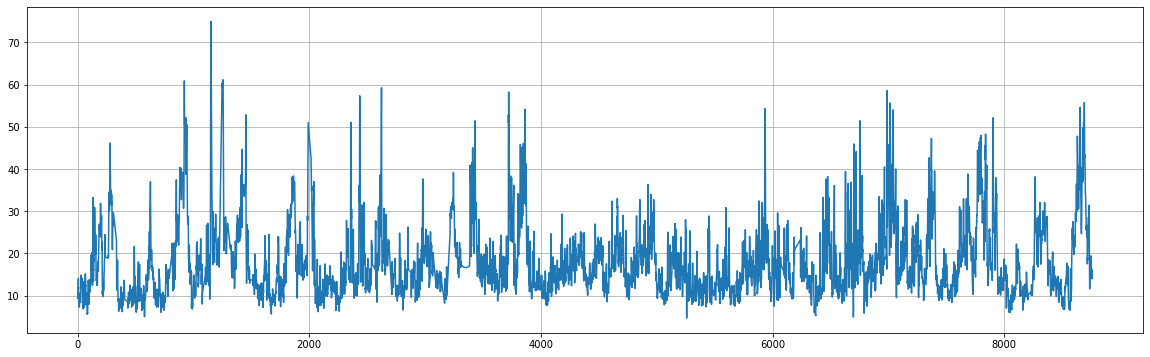

In [33]:
Cext=np.loadtxt("https://raw.githubusercontent.com/eddes/buildingphysics/master/chapter_2/2_IAQ_filtration/PM25.txt")

# total timelength of the dataset, in hours
t_max=len(Cext)
time=np.arange(0,t_max,1)

# Plotting the PM25 distribution over time
plt.rcParams["figure.figsize"] = (20,6)
plt.grid()
plt.plot(time,Cext)

### Main function definition

This main function performs the following

- Initialize variable arrays
- Compute the evolution of indoor concentration, filter clogging, filter efficiency, power consumption
- Plot results

These steps are described along the code.

In [40]:

def simulate_filter_evolution(qv,  m_limit):
    nb_filt = 0
    # prepare variable arrays
    # Concentration of particule of the ventilation stream coming into the room
    Csupply=np.zeros(nb)
    
    # Concentration of particule inside the room
    C=np.zeros(nb)

    # Dust mass in filter
    m_filter=np.zeros(nb) # initialy nothing in filter
    
    # Filter efficiency
    eta_filter=np.ones(nb)*eta # initial eta for eta_filter[0] actually (will be updated in the time loop)
    
    # Pressure drop caused by the filter
    pdc_filter=np.zeros(nb)
    
    Csupply[0]=Cext[0] # aesthetical fill for plotting
    m_filter[0]=1e-4 # against division by !0
    pdc_ref=fc_pressure_drop(0) # reference pressure drop for clean filter
    
    # Running the simulation 
    for t in range(1,t_max-1):
        # compute the filter efficiency
        eta_filter[t]=fc_eta(m_filter[t-1])
        
        # compute the additionnal pressure drop compared to the one for a clean filter
        pdc_filter[t]=fc_pressure_drop(m_filter[t-1])-pdc_ref 
        
        # PM2.5 concentration supplied to the room
        Csupply[t]=(1-eta_filter[t])*Cext[t]
        
        # mass in filter, converted to grams
        m_filter[t]=(Cext[t]-Csupply[t])*qv/1e6 + m_filter[t-1]
        
        # check if we change the filter
        if m_filter[t]>m_limit:
            m_filter[t]=0
            nb_filt+=1 # count the number of filter change 
            
        #explicit scheme for C+ (=C[t] here)
        C[t]=C[t-1] + dt*tau*(Csupply[t]-C[t-1])
        
    # compute the energy use for reference
    watts_hourly=pdc_filter*qv/3600
    total_kWh=sum(watts_hourly)/1000
    
    
    # post process and plotting
    # Creating a panda dataframe
    a=pd.date_range('1/1/2018', periods=8760, freq='h')
    dfC = pd.DataFrame(index=a)
    
    dfC["PM25"]=Csupply
    dfC["PM25_ext"]=Cext
    dfC["eta"]=eta_filter
    dfC["mass"]=m_filter
    dfC["pdc"]=pdc_filter
    
    # get rid off the last empty index
    dfC=dfC.drop(dfC.index[-1])
    
    # Computing the average values per hours over a week for outdoor and indoor concentrations
    typical_week_filt=fc_semaine_type_series(dfC["PM25"],"semaine")
    typical_week_ext=fc_semaine_type_series(dfC["PM25_ext"],"semaine")
    
    # Plotting
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5)

    ax1.set_xlabel("Average PM concentration per week [h]]")
    ax1.grid()
    ax1.set_ylabel(r"$PM_{2.5}$[µg/m$^3$]")
    ax1.plot(typical_week_ext, color=colors[-1], linestyle="-", alpha=0.9, marker='', label='outdoor')
    ax1.plot(typical_week_filt, color=colors[0], linestyle="-", alpha=0.9, marker='', label='indoor')
    ax1.legend()

    ax2.set_xlabel("Filter efficiency")
    ax2.set_ylabel("Efficiency [-]")
    ax2.grid()
    ax2.plot(dfC["eta"],color=colors[2], linestyle="--", alpha=1, marker='')
    ax2.plot()

    ax3.set_xlabel("Filter mass")
    ax3.set_ylabel("Mass in filter [g]")
    ax3.grid()
    ax3.plot(dfC["mass"],color=colors[3], linestyle="--", alpha=1, marker='')
    ax3.plot()

    ax4.grid()
    ax4.set_xlabel("Filter PDC")
    ax4.set_ylabel(r"Additional pressure drop of filter [$\Delta$ Pa]")
    ax4.plot(dfC["pdc"], color=colors[4], linestyle="--", alpha=1, marker='')
    ax4.plot()
    
    ax5.set_xlabel("PM25 over the year")
    ax5.grid()
    ax5.set_ylabel(r"$PM_{2.5}$[µg/m$^3$]")
    ax5.plot(dfC["PM25"], color=colors[-1], linestyle="--", alpha=0.5, marker='')
    ax5.plot()


Creating interactive plot.
             

In [41]:
plt.rcParams["figure.figsize"] = (20,30)

interact_manual(simulate_filter_evolution, qv = widgets.FloatSlider(value=2000,    min=1,
                                               max=10000.0,
                                               step=0.1),
                
                m_limit = widgets.FloatSlider(value=30,    min=1,
                                               max=75.0,
                                               step=0.1)
                 )

interactive(children=(FloatSlider(value=2000.0, description='qv', max=10000.0, min=1.0), FloatSlider(value=30.…

<function __main__.simulate_filter_evolution(qv, m_limit)>